<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_Corn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 5.77 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 14:00:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Corn'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 9.3 MB/s 
     |████████████████████████████████| 133 kB 51.2 MB/s 
     |████████████████████████████████| 97 kB 7.5 MB/s 
     |████████████████████████████████| 138 kB 42.8 MB/s 
     |████████████████████████████████| 170 kB 50.6 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 62 kB 909 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: ucphf2s3
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/ucphf2s3


In [16]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: qzxjkbh5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 3s 35ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1570 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1720
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0744 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1285
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0583 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1588
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0595 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1372
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0045 - mean_squared_error

epoch,49
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.02824
val_loss,0.00781
val_mean_squared_error,0.00781
val_mean_absolute_error,0.06871
_runtime,26
_timestamp,1627050301
_step,49
best_val_loss,0.00724


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▄█▅▃▂▂▂▂▂▃▁▂▂▁▁▁▂▁▁▁▁▃▁▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄█▅▃▂▂▂▂▂▃▁▂▂▁▁▁▂▁▁▁▁▃▁▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▇▆▃▂▃▃▂▂▃▁▂▂▂▁▁▃▁▁▁▂▃▁▄▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jpaj0dmq with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 56ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1275 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1328
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0507 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1198
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0457 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1133
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0428 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1112
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_error

epoch,49
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02463
val_loss,0.00902
val_mean_squared_error,0.00902
val_mean_absolute_error,0.07061
_runtime,18
_timestamp,1627050326
_step,49
best_val_loss,0.00902


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: j7ude7n7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 58ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: 

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,10
_timestamp,1627050355
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▁▅▅▅▅▅█
_timestamp,▁▁▁▁▅▅▅▅▅█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 4y0crih4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 58ms/step - loss: 0.1417 - mean_squared_error: 0.1417 - mean_absolute_error: 0.3322 - val_loss: 0.2167 - val_mean_squared_error: 0.2167 - val_mean_absolute_error: 0.4059
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.1078 - mean_squared_error: 0.1078 - mean_absolute_error: 0.2721 - val_loss: 0.1519 - val_mean_squared_error: 0.1519 - val_mean_absolute_error: 0.3270
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1810 - val_loss: 0.1017 - val_mean_squared_error: 0.1017 - val_mean_absolute_error: 0.2601
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1302 - val_loss: 0.0726 - val_mean_squared_error: 0.0726 - val_mean_absolute_error: 0.2157
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0313 - mean_squared_

epoch,99
loss,0.00325
mean_squared_error,0.00325
mean_absolute_error,0.04273
val_loss,0.01988
val_mean_squared_error,0.01988
val_mean_absolute_error,0.11535
_runtime,32
_timestamp,1627050394
_step,99
best_val_loss,0.01988


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0fhou8r8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 61ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - mean_absolute_error: 0.1943 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1425
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0723 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1492
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0533 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1183
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0435 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1021
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0021 - mean_squared_

epoch,61
loss,0.00069
mean_squared_error,0.00069
mean_absolute_error,0.01995
val_loss,0.0055
val_mean_squared_error,0.0055
val_mean_absolute_error,0.05629
_runtime,23
_timestamp,1627050424
_step,61
best_val_loss,0.005


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▃▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▃▃▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▅▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: geal9u4i with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 116ms/step - loss: 0.1240 - mean_squared_error: 0.1240 - mean_absolute_error: 0.2778 - val_loss: 0.0387 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1503
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1167 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1445
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0952 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1366
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0813 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1740
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0202 - mean_squared_error: 0.

epoch,49
loss,0.03354
mean_squared_error,0.03354
mean_absolute_error,0.12605
val_loss,0.06555
val_mean_squared_error,0.06555
val_mean_absolute_error,0.201
_runtime,16
_timestamp,1627050450
_step,49
best_val_loss,0.00889


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▃▂▂▂▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▃▃▃▃▃
mean_squared_error,█▂▂▂▃▂▂▂▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▃▃▃▃▃
mean_absolute_error,█▄▃▂▄▃▃▂▂▂▁▂▂▂▂▂▁▂▁▂▂▂▂▁▂▂▁▂▁▂▁▁▁▃▅▄▄▄▄▄
val_loss,▃▃▂▃█▂▂▂▃▁▂▁▁▁▃▁▃▁▁▁▂▁▂▁▂▁▁▂▁▁▁▁▁▂▅▅▅▅▄▅
val_mean_squared_error,▃▃▂▃█▂▂▂▃▁▂▁▁▁▃▁▃▁▁▁▂▁▂▁▂▁▁▂▁▁▁▁▁▂▅▅▅▅▄▅
val_mean_absolute_error,▄▃▃▄█▃▃▃▄▂▃▂▂▂▄▁▄▂▂▂▃▂▂▁▄▁▁▃▂▂▁▁▁▂▅▅▆▆▅▅
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eo6adf79 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 117ms/step - loss: 0.1271 - mean_squared_error: 0.1271 - mean_absolute_error: 0.3105 - val_loss: 0.1240 - val_mean_squared_error: 0.1240 - val_mean_absolute_error: 0.2900
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1316 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1827
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1663 - val_loss: 0.0582 - val_mean_squared_error: 0.0582 - val_mean_absolute_error: 0.1904
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1226 - val_loss: 0.0694 - val_mean_squared_error: 0.0694 - val_mean_absolute_error: 0.2105
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0305 - mean_squared_error: 0.0305 

epoch,49
loss,0.00214
mean_squared_error,0.00214
mean_absolute_error,0.03473
val_loss,0.01547
val_mean_squared_error,0.01547
val_mean_absolute_error,0.10149
_runtime,15
_timestamp,1627050473
_step,49
best_val_loss,0.01547


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g4dyvrm3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 61ms/step - loss: 0.2133 - mean_squared_error: 0.2133 - mean_absolute_error: 0.3235 - val_loss: 0.5833 - val_mean_squared_error: 0.5833 - val_mean_absolute_error: 0.7311
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 1894868859981.5750 - mean_squared_error: 1894868859981.5750 - mean_absolute_error: 62282.8603 - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: nan - mean_squared_error: nan - mean_ab

epoch,10
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,9
_timestamp,1627050490
_step,10
best_val_loss,0.58332


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▁█
mean_squared_error,▁█
mean_absolute_error,▁█
val_loss,▁
val_mean_squared_error,▁
val_mean_absolute_error,▁
_runtime,▁▃▃▃▃▃▆▆▆▆█
_timestamp,▁▃▃▃▃▃▆▆▆▆█
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: eyb7b6ls with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 3s 36ms/step - loss: 0.0879 - mean_squared_error: 0.0879 - mean_absolute_error: 0.2208 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1453
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0600 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1353
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0463 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1082
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0361 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0948
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0019 - mean_squared_

epoch,65
loss,0.00071
mean_squared_error,0.00071
mean_absolute_error,0.01992
val_loss,0.00703
val_mean_squared_error,0.00703
val_mean_absolute_error,0.06437
_runtime,38
_timestamp,1627050535
_step,65
best_val_loss,0.00517


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gtgb42oy with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 64ms/step - loss: 1.8861 - mean_squared_error: 1.8861 - mean_absolute_error: 1.0310 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1642
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0962 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1395
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1039 - val_loss: 0.0668 - val_mean_squared_error: 0.0668 - val_mean_absolute_error: 0.2194
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 0.2105 - mean_squared_error: 0.2105 - mean_absolute_error: 0.2829 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1621
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0111 - mean_squared_error

epoch,34
loss,0.0176
mean_squared_error,0.0176
mean_absolute_error,0.09524
val_loss,0.01265
val_mean_squared_error,0.01265
val_mean_absolute_error,0.08839
_runtime,16
_timestamp,1627050567
_step,34
best_val_loss,0.01154


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▃▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
mean_squared_error,█▁▁▃▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
mean_absolute_error,█▂▂▅▂▃▂▂▃▂▄▁▃▂▁▂▂▁▂▁▂▁▂▁▃▁▁▃▁▁▁▃▁▁▂
val_loss,▁▁▁▁▁▂▁▁▁▂▁▁▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▂▁▁▁▂▁▁▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▁▂▂▁▄▁▂▁▃▁▁▄▁▁█▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2mb1avxi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 68ms/step - loss: 0.0738 - mean_squared_error: 0.0738 - mean_absolute_error: 0.2101 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1698
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0813 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1371
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0601 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1193
Epoch 4/50
16/16 [==============================] - 0s 21ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0550 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1030
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0052 - mean_squared_error

epoch,49
loss,0.00072
mean_squared_error,0.00072
mean_absolute_error,0.02023
val_loss,0.00652
val_mean_squared_error,0.00652
val_mean_absolute_error,0.06299
_runtime,26
_timestamp,1627050601
_step,49
best_val_loss,0.00641


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▃▂▃▁▂▂▂▁▂▂▃▂▂▁▂▂▂▁▂▁▂▁▂▁▁▂▁▂▂▁▁▂▁
val_loss,█▅▄▃▃▃▂▂▃▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▃▁▁▁▂▁▁▁▁▁▅▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▂▂▃▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▃▁▁▁▂▁▁▁▁▁▅▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▃▃▄▂▂▂▂▃▂▂▃▂▃▃▂▂▃▂▄▁▁▁▂▁▂▁▁▂▆▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k2k5ojpg with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 65ms/step - loss: 121.8942 - mean_squared_error: 121.8942 - mean_absolute_error: 7.8975 - val_loss: 85.4604 - val_mean_squared_error: 85.4604 - val_mean_absolute_error: 9.2141
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 51.7742 - mean_squared_error: 51.7742 - mean_absolute_error: 6.1160 - val_loss: 25.1967 - val_mean_squared_error: 25.1967 - val_mean_absolute_error: 4.4944
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 36.0067 - mean_squared_error: 36.0067 - mean_absolute_error: 4.7108 - val_loss: 9.0799 - val_mean_squared_error: 9.0799 - val_mean_absolute_error: 2.8407
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 21.6189 - mean_squared_error: 21.6189 - mean_absolute_error: 3.9264 - val_loss: 34.5647 - val_mean_squared_error: 34.5647 - val_mean_absolute_error: 5.3642
Epoch 5/50
16/16 [==============================] - 0s 17ms/step - loss: 31.5467 - m

epoch,27
loss,1.42442
mean_squared_error,1.42442
mean_absolute_error,0.96671
val_loss,1.18608
val_mean_squared_error,1.18608
val_mean_absolute_error,1.05698
_runtime,17
_timestamp,1627050626
_step,27
best_val_loss,0.33176


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▂▃▃▃▃▄▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▃▃▃▃▄▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▅▅▅▅▅▅▄▃▃▃▂▃▃▃▂▂▂▁▁▁▁▁▁▁
val_loss,█▃▂▄▄▄▁▇▂▁▁▁▂▁▃▂▂▁▁▃▁▁▂▁▁▁▁▁
val_mean_squared_error,█▃▂▄▄▄▁▇▂▁▁▁▂▁▃▂▂▁▁▃▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▄▃▅▆▅▁▇▄▂▂▂▃▁▄▃▃▁▂▄▂▂▃▂▁▂▂▁
_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: nhgzwsi5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100


wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [17]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 64,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [18]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [20]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
20/20 [==============================] - 2s 7ms/step - loss: 0.3995
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0072
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 5/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 8/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 9/50
20/20 [==============================] - 0s 8ms/step - loss: 9.0841e-04
Epoch 10/50
20/20 [==============================] - 0s 8ms/step - loss: 8.9005e-04
Epoch 11/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 12/50
20/20 [==============================] - 0s 7ms/step - loss: 9.0757e-04
Epoch 13/50
20/20 [==================

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

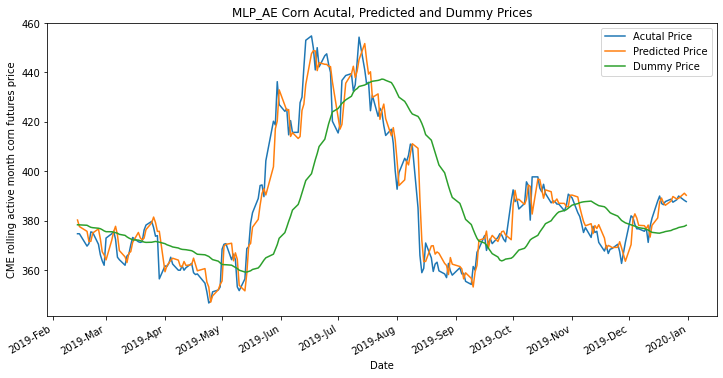

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

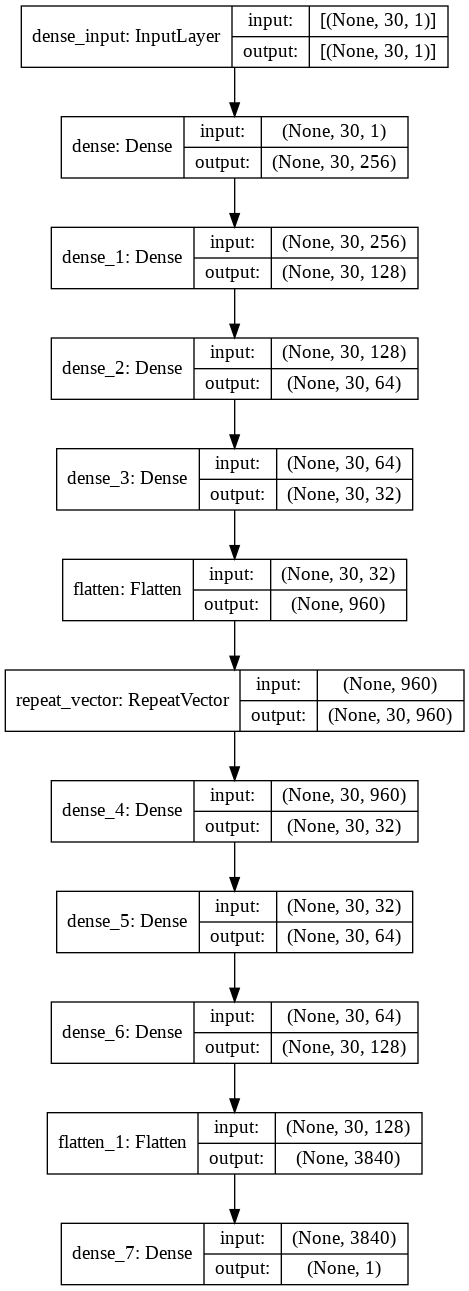

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0035708881121975303
RMSE:  0.059756908489291265
MAE:  0.04311835992679529
Dummy MSE:  0.041446864361575214
Dummy RMSE:  0.20358502980714277
Dummy MAE:  0.15160472972972977


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_Corn/assets
